<a href="https://colab.research.google.com/github/hws2002/MachineLearning_PytorchNScikitLearn/blob/master/chapter3/chapter3_4_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'Colab Notebooks/pyml/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/pyml
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from utils.plot_decision_regions import plot_decision_boundary
from utils.load_data import load_iris_from_skl

# 3.4 최대 마진
* SVM의 최적화 대상은 '마진' 임.
* 마진은 클래스를 구분하는 **초평면(결정 경계)과 이 초평면에 가장 가까운 훈련 샘플 사이의 거리로** 정의함.
* 그러한 샘플을 **서포트 벡터** 라고 함.

### 수학적 배경을 알고 싶다면 아래 링크들 참고
* [Chris J. C. Burges의 책](https://www.di.ens.fr/~mallat/papiers/svmtutorial.pdf)
* [book of vladimir vapnik](https://statisticalsupportandresearch.wordpress.com/wp-content/uploads/2017/05/vladimir-vapnik-the-nature-of-statistical-learning-springer-2010.pdf)
* [CS229](https://see.stanford.edu/materials/aimlcs229/cs229-notes3.pdf)

# 3.5 슬랙 변수를 사용하여 비선형 분류 문제 다루기

블라드미르 바프닉이 소개한 슬랙 변수를 활용한 비선형 분류를 **소프트 마진 분류(soft margin classification)** 이라고 함. (슬랙 변수가 없는 경우를 hard-margin 분류라고도 함)  
슬랙 변수는 선형적으로 구분되지 않은 데이터에서 SVM 최적화목적 함수에 있는 선형 제약 조건을 완화할 필요가 있기 때문에 도입됨.  
이를 통해 적절히 손실을 손해 보면서 분류 오차가 있는 상황에서 최적화 알고리즘이 수렴함.

사이킷런에서는 매개변수 C를 통해 이 슬랙변수를 조정하는데,
앞전에 logistic regression할때와 똑같이, C값이 크면 오차에 대한 손실이 커지고,(즉, 오차에 더 민감해짐, 더 완벽한 경계를 그리려고 함) C값이 작으면 분류 오차에 덜 엄격해짐.  
결론 : C매개변수를 사용하여 마진 폭을 제어할 수 있음

In [ ]:
# load dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X,y = load_iris_from_skl()
X = X[:,[2,3]]

# split
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size = 0.3, random_state = 1, shuffle = True, stratify = y)

# standardization
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# check label count
print('y_train label count : ', np.bincount(y_train))
print('y_test label count : ', np.bincount(y_test))

X_combined_std = np.vstack((X_train_std,X_test_std))
y_combined = np.hstack((y_train,y_test))

y_train label count :  [35 35 35]
y_test label count :  [15 15 15]


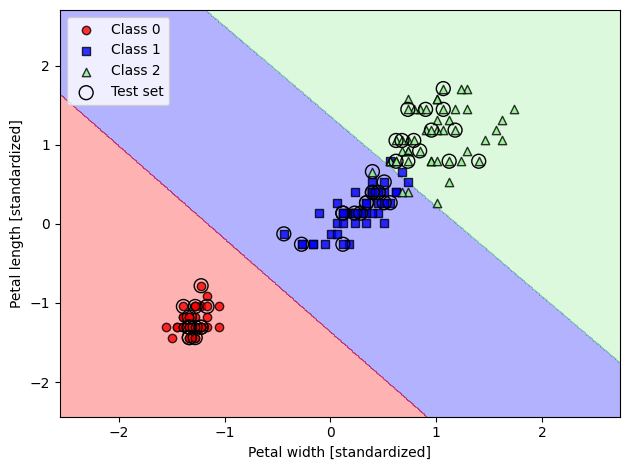

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear', C = 1.0, random_state = 1)
svm.fit(X_train_std, y_train)
plot_decision_boundary(X_combined_std, y_combined, classifier = svm, test_idx = range(105,150))
plt.xlabel('Petal width [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

In [34]:
print("number of unique classes : ", svm.classes_)
print("number of support vectors per class :", svm.n_support_)

number of unique classes :  [0 1 2]
number of support vectors per class : [ 2 13 11]


## (optional) playing with support vectors
svm 객체의 dual_coef_ 속성에서 서포트 벡터를 확인할 수 있음
좀더 자세히 알아보려면 아래 글을 참고하자

[The dimension of dual_coef_ in sklearn. SVC](https://stackoverflow.com/questions/22816646/the-dimension-of-dual-coef-in-sklearn-svc)

In [ ]:
# svm 객체의 dual_coef_ 속성에서 서포트 벡터를 확인할 수 있음
svm.dual_coef_

array([[ 0.88134491,  0.60379849, -1.        , -0.        , -0.        ,
        -0.        , -0.        , -0.4851434 , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.39455455],
       [ 0.39455455,  0.        ,  0.        ,  1.        ,  0.19375927,
         1.        ,  1.        ,  0.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -0.19375927, -1.        ,
        -1.        ]])

In [40]:
support_indices = np.cumsum(svm.n_support_)
print(svm.dual_coef_[0:support_indices[0]])
print(svm.dual_coef_[support_indices[1] : support_indices[2]])


[[ 0.88134491  0.60379849 -1.         -0.         -0.         -0.
  -0.         -0.4851434  -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.39455455]
 [ 0.39455455  0.          0.          1.          0.19375927  1.
   1.          0.          1.          1.          1.          1.
   1.          1.          1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -0.19375927
  -1.         -1.        ]]
[]


In [36]:
svm.coef_

array([[-1.28108835, -1.08908074],
       [-0.68216416, -0.56900015],
       [-2.20580665, -1.9370517 ]])